The goal of this code is the building of an SI-RCNN model to forcast closing price directional movements.

The first step is the loading of seven technical indicators from our stock of choice. For the remit of this assignment we used the S&P 500.

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import import_ipynb
import layers_nt


start_date = "2007-12-31"
end_date = "2017-12-31"
technical_layer = layers_nt.calculate_technical_indicator(start_date,end_date)
technical_layer.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume,Stochastic_%K,Williams_%R,Stochastic_%D,AD_Line,AD_Oscillator,Momentum,Disparity,ROC
Ticker,,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,,,,,,,,
2,2008-01-03,1447.160034,1456.800049,1443.729980,1447.550049,3429500000,15.077270,-84.922730,13.078558,-5.271027e+09,-4.865881e+09,-31.329956,99.514061,-2.119051
3,2008-01-04,1411.630005,1444.010010,1411.189941,1444.010010,4166000000,0.726416,-99.273584,7.901843,-9.325308e+09,-7.952933e+09,-56.729980,98.349724,-3.863493
4,2008-01-07,1416.180054,1423.869995,1403.449951,1414.069946,4221260000,23.861442,-76.138558,12.293929,-8.283399e+09,-4.641825e+09,-30.979980,99.381752,-2.140743
5,2008-01-08,1390.189941,1430.280029,1388.300049,1415.709961,4705390000,3.392378,-96.607622,13.626910,-1.256513e+10,-7.294099e+09,-56.970093,98.875529,-3.936682
6,2008-01-09,1409.130005,1409.189941,1378.699951,1390.250000,5351030000,58.995750,-41.004250,31.194064,-7.235134e+09,2.090174e+09,-2.500000,100.282055,-0.177100


The next step was to create another input of financial news sentence embeddings, for this we used the FNSPID dataset which hold millions of financial news records covering S&P 500 companies.

https://github.com/Zdong104/FNSPID_Financial_News_Dataset

We manually cleaned the dataset by removing some of the lower rows that had garbage data upon downloaded. Following this we loaded it into python sorted it by date and removed all other columns before saving it again so we may reduce how many times this section is run. We then reduce it to the 10 year date range of 2007-2017 which will be our training window.

The below function extracts a date-filtered subset of news article data the datasets csv file and saves it to a new file for later use. This method increased processing time when repeating experiments as it meant we didnt have to load the entire unprocessed CSV every single time.

We cleaned the dataset by using only a range of values and removing any unneccasry columns, we also include some articles before the start date reflective of our lookback period so we dont end up with null values.

We commented out the call for the function but it is quite simple to use.

In [3]:
def extract_embedding_data(start_date,end_date,out_filename,lookback):
    start_date = pd.to_datetime(start_date) - pd.Timedelta(days=lookback)
    full_csv = pd.read_csv('All_external.csv',usecols=['Article_title', 'Date'])  
    full_csv = full_csv.sort_values('Date').reset_index(drop=True)  
    full_csv = full_csv.set_index('Date')

    filtered_csv = full_csv.loc[str(start_date):end_date]
    filtered_csv.to_csv(out_filename)

# extract_embedding_data('2007-12-31','2017-12-31','train2007_2017.csv',3)

First we tokenize the titles, we handled quotations as this caused some parsing issues. Next we create a sentence embeddings by averaging the word vectors. Finally we merge both layers into one variable, this helps ensure that they match in length. See the layers_nt.ipynb for further breakdown of the individual functions.

In [4]:
trading_days = pd.to_datetime(technical_layer['Date']).dt.tz_localize(None).dt.date
daily_news_trading_days = layers_nt.calculate_embedding_layer('train2007_2017.csv',trading_days)
merged = technical_layer
merged['sentence_vector'] = daily_news_trading_days['sentence_vector']
merged

Price,Date,Close,High,Low,Open,Volume,Stochastic_%K,Williams_%R,Stochastic_%D,AD_Line,AD_Oscillator,Momentum,Disparity,ROC,sentence_vector
Ticker,,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,,,,,,,,,
2,2008-01-03,1447.160034,1456.800049,1443.729980,1447.550049,3429500000,15.077270,-84.922730,13.078558,-5.271027e+09,-4.865881e+09,-31.329956,99.514061,-2.119051,"[0.7732097874789102, 0.6990763421888123, -0.07..."
3,2008-01-04,1411.630005,1444.010010,1411.189941,1444.010010,4166000000,0.726416,-99.273584,7.901843,-9.325308e+09,-7.952933e+09,-56.729980,98.349724,-3.863493,"[0.7721021591249322, 0.6454370597753164, -0.06..."
4,2008-01-07,1416.180054,1423.869995,1403.449951,1414.069946,4221260000,23.861442,-76.138558,12.293929,-8.283399e+09,-4.641825e+09,-30.979980,99.381752,-2.140743,"[0.7085644439629866, 0.5538316975121838, -0.04..."
5,2008-01-08,1390.189941,1430.280029,1388.300049,1415.709961,4705390000,3.392378,-96.607622,13.626910,-1.256513e+10,-7.294099e+09,-56.970093,98.875529,-3.936682,"[0.7136855754850101, 0.5603985191664088, -0.05..."
6,2008-01-09,1409.130005,1409.189941,1378.699951,1390.250000,5351030000,58.995750,-41.004250,31.194064,-7.235134e+09,2.090174e+09,-2.500000,100.282055,-0.177100,"[0.7805759518318046, 0.45213355969951324, 0.00..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514,2017-12-22,2683.340088,2685.350098,2678.129883,2684.219971,2401030000,43.739107,-56.260893,44.946579,1.202022e+12,-2.711157e+09,1.870117,100.035542,0.069742,"[0.19312299859549079, 0.7272546675746603, -0.3..."
2515,2017-12-26,2680.500000,2682.739990,2677.959961,2679.090088,1970660000,17.302799,-82.697201,30.520953,1.202145e+12,-7.093981e+08,1.250000,99.914143,0.046655,"[0.16773971059185844, 0.7397754483772587, -0.4..."
2516,2017-12-27,2682.620117,2685.639893,2678.909912,2682.100098,2202900000,60.679658,-39.320342,38.991228,1.202371e+12,1.413899e+09,-1.949951,100.017401,-0.072636,"[0.1667256240423994, 0.7894552056691944, -0.33..."


Here we prepare the data using a sliding window approach with a lookback period. We split the data finally into the news and tech portions, we also calculate our target variable y by loading it with the prive movements of the stock. 

The final shape of the input layers were (N,L,I), where N is the number of observations (2513 days in our case), L is the lookback period which was set statically to 3, and I is the input vector which was 7 and 100 for the technical and new layers respectively. 

In [5]:
lookback = 3
X_news = []
X_tech = []
y = []

for i in range(lookback, len(merged) - 1):
    news_seq = np.stack(merged['sentence_vector'].iloc[i-lookback:i].values)
    tech_seq = merged[['Stochastic_%K', 'Williams_%R', 'Stochastic_%D',
                       'AD_Oscillator', 'Momentum', 'Disparity', 'ROC']].iloc[i-lookback:i].values
    if np.isnan(news_seq).any() or np.isnan(tech_seq).any():
        continue

    today_close = merged['Close'].iloc[int(i)]
    next_close = merged['Close'].iloc[int(i) + 1]
    label = 1 if float(next_close.iloc[0]) > float(today_close.iloc[0]) else 0

    X_news.append(news_seq)
    X_tech.append(tech_seq)
    y.append(label)

X_news = np.array(X_news)
X_tech = np.array(X_tech) 
y = np.array(y) 

print("News shape:", X_news.shape)
print("Tech shape:", X_tech.shape)
print("Labels shape:", y.shape)

News shape: (2513, 3, 100)
Tech shape: (2513, 3, 7)
Labels shape: (2513,)


This code implements a time series cross-validation framework to train and evaluate a neural network model. we split the dataset into 5 folds which each fold roughly translating to two years. To help visualize the training and testing splits generated we plotted the splits using different colurs to help identify them. In this case were showing the dataset at the last iteration of training with the test set appended at the end for visual completeness.

[*********************100%***********************]  1 of 1 completed


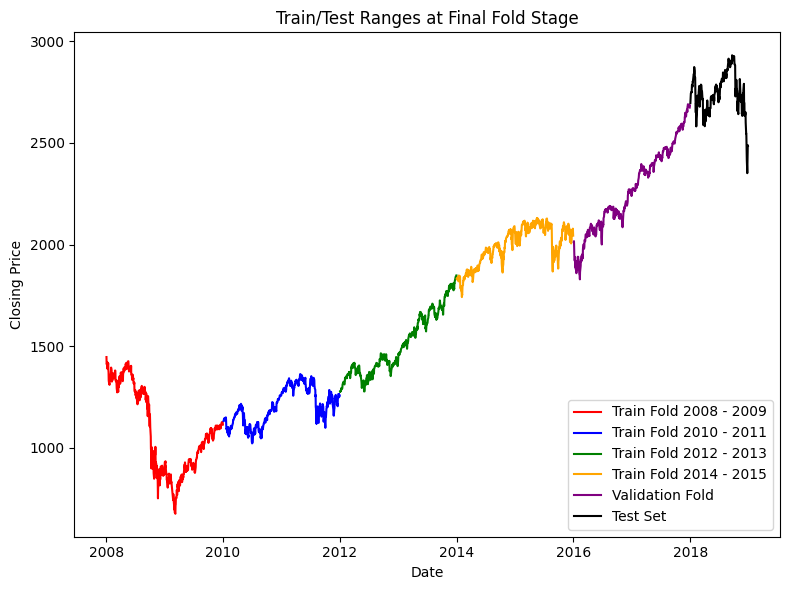

In [29]:
from sklearn.model_selection import TimeSeriesSplit
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


X_news_tensor = torch.tensor(X_news, dtype=torch.float32)
X_tech_tensor = torch.tensor(X_tech, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

tscv = TimeSeriesSplit(n_splits=5)
fold = 1

plt.figure(figsize=(8, 6))
fold_ranges = [("2008-01-01", "2009-12-31"),("2010-01-01", "2011-12-31"),("2012-01-01", "2013-12-31"),("2014-01-01", "2015-12-31")]
colours = ['red', 'blue', 'green', 'orange' ]

for i, (start_date, end_date) in enumerate(fold_ranges):
    date_mask = (technical_layer['Date'] >= start_date) & (technical_layer['Date'] <= end_date)
    plt.plot(technical_layer.loc[date_mask, 'Date'], technical_layer.loc[date_mask, 'Close'], color=colours[i], label=f"Train Fold {start_date[:4]} - {end_date[:4]}")

date_mask = (technical_layer['Date'] >= "2016-01-01") & (technical_layer['Date'] <= "2017-12-31")
plt.plot(technical_layer.loc[date_mask, 'Date'], technical_layer.loc[date_mask, 'Close'], color='purple', label='Validation Fold')

test_set = yf.download("^GSPC", start="2018-01-01", end="2018-12-31", interval="1d").reset_index()
plt.plot(test_set['Date'], test_set['Close'], color='black', label='Test Set')

plt.title("Train/Test Ranges at Final Fold Stage")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

During training, the model is penalized if the predicted "up" class ratio (the naive buy signal) exceeds specific thresholds, introducing a naive penalty to discourage the model from overfitting to only predict up.

The code incorporates an early stopping mechanism, halting training within a fold if validation loss doesn't improve beyond a small threshold for a set number of epochs, which helps prevent overfitting and reduces unnecessary training time. 

In [ ]:
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader
import copy
import model_nt

patience = 10
delta = 0.001

best_acc = 0.0
best_model_state = None

for train_idx, test_idx in tscv.split(X_news_tensor):
    print(f"\n--- Fold {fold} ---")

    train_dataset = TensorDataset(X_news_tensor[train_idx], X_tech_tensor[train_idx], y_tensor[train_idx])
    test_dataset = TensorDataset(X_news_tensor[test_idx], X_tech_tensor[test_idx], y_tensor[test_idx])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = model_nt.NewsTechLSTM()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    best_val_loss = np.inf
    epochs_no_improve = 0
    early_stop = False

    model.train()
    for epoch in range(50):
        total_loss = 0
        for news_batch, tech_batch, y_batch in train_loader:
            optimizer.zero_grad()
            out = model(news_batch, tech_batch)
            loss = loss_fn(out, y_batch)
            preds = torch.argmax(out, dim=1)
            up_ratio = (preds == 1).float().mean().item()
            if up_ratio >= 0.97 :
                penalty = 0.5
                loss += penalty
            elif up_ratio >= 0.9 :
                penalty = 0.1
                loss += penalty
            loss.backward()
            optimizer.step()
            total_loss += loss.item()      
        avg_loss = total_loss / len(train_loader)
        #print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

    # Validation (test set for this fold)
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for news_batch, tech_batch, y_batch in test_loader:
                out = model(news_batch, tech_batch)
                loss = loss_fn(out, y_batch)
                val_loss += loss.item()
                preds = torch.argmax(out, dim=1)
                all_preds.extend(preds.numpy())
                all_labels.extend(y_batch.numpy())
        print(all_preds)
        avg_val_loss = val_loss / len(test_loader)
        acc = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch+1}: Train Loss={avg_loss:.4f}, Val Loss={avg_val_loss:.4f}, Val Acc={acc:.4f}")

        # Early stopping logic
        if avg_val_loss < best_val_loss - delta:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_fold_model_state = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                early_stop = True
                model.load_state_dict(best_fold_model_state)
                break

    # Final evaluation for this fold
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for news_batch, tech_batch, y_batch in test_loader:
            out = model(news_batch, tech_batch)
            preds = torch.argmax(out, dim=1)
            all_preds.extend(preds.numpy())
            all_labels.extend(y_batch.numpy())
            
    acc = accuracy_score(all_labels, all_preds)
    print(f"Fold {fold} Accuracy: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_model_state = copy.deepcopy(model.state_dict())

    fold += 1

torch.save(best_model_state, 'best_news_tech_model.pt')
print(f"\nBest model saved with accuracy: {best_acc:.4f}")


--- Fold 1 ---
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

This code evaluates the previously trained model on a testing set from the year 2018. It loads the best model checkpoint obtained from cross-validation and switches the model into evaluation mode. We then process the data similar to the previous sections.

In [ ]:
model = model_nt.NewsTechLSTM()
model.load_state_dict(torch.load("best_news_tech_model.pt"))
model.eval()
technical_indicators = layers_nt.calculate_technical_indicator(start_date='2018-01-01', end_date='2018-12-31')
trading_days = pd.to_datetime(technical_indicators['Date']).dt.tz_localize(None).dt.date
daily_news_trading_days = layers_nt.calculate_embedding_layer('test2018.csv',trading_days)

merged = technical_indicators
merged['sentence_vector'] = daily_news_trading_days['sentence_vector']
y_true,y_pred = [], []

for i in range(lookback, len(merged) - 1):
    news_seq = np.stack(merged['sentence_vector'].iloc[i-lookback:i].values)
    tech_seq = merged[['Stochastic_%K', 'Williams_%R', 'Stochastic_%D','AD_Oscillator', 'Momentum', 'Disparity', 'ROC']].iloc[i-lookback:i].values

    news_tensor = torch.tensor(news_seq[np.newaxis, ...], dtype=torch.float32)
    tech_tensor = torch.tensor(tech_seq[np.newaxis, ...], dtype=torch.float32)

    with torch.no_grad():
        out = model(news_tensor, tech_tensor)
        pred = torch.argmax(out, dim=1).item()

    today_close = merged['Close'].iloc[int(i)]
    next_close = merged['Close'].iloc[int(i) + 1]
    label = 1 if float(next_close.iloc[0]) > float(today_close.iloc[0]) else 0
    
    y_pred.append(pred)
    y_true.append(label)


[*********************100%***********************]  1 of 1 completed


This code evaluates the performance of our model, it compares the models predictions to the true labels of the previously processed 2018. We tabulated the results in the write up.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, balanced_accuracy_score

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

print(f"\nModel Performance on 2018 test set")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")